In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from myfunctions import set_importer, scores
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, plot_confusion_matrix, log_loss, make_scorer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.base import clone

pd.set_option('display.max_columns', None)

sns.set_style("whitegrid")
%matplotlib inline

# setting font size for all plots
font = {'size'   : 16}

plt.rc('font', **font)

In [2]:
# import X_train_encoded, X_test_encoded, y_train and y_test
X_train = set_importer('../analysis-dfs/X_train_prepared.csv')
X_test = set_importer('../analysis-dfs/X_test_prepared.csv')

y_train = set_importer('../analysis-dfs/y_train_prepared.csv', y=True)
y_test = set_importer('../analysis-dfs/y_test_prepared.csv', y=True)

display(X_train.shape)
X_train.head(10)

(29852, 47)

,gps_height,longitude,latitude,region_code,district_code,population,permit,construction_year,basin_lake nyasa,basin_lake rukwa,basin_lake tanganyika,basin_lake victoria,basin_pangani,basin_rufiji,basin_ruvuma / southern coast,basin_wami / ruvu,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_class_surface,source_class_unknown,waterpoint_type_group_communal standpipe,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,-0.356274,1.723728,-1.640197,-0.393261,-0.194167,1.366671,0.66262,0.801349,-0.272276,-0.24457,-0.36545,-0.484293,-0.398664,-0.340700,3.031980,-0.334300,-0.535902,-0.277124,-0.493551,-0.072457,2.973812,-0.048039,-0.115144,-0.162114,-0.113125,0.345098,-0.129342,-0.185442,-0.335648,-0.342545,-0.241720,-0.463142,-0.048039,0.476945,-0.116884,-0.330131,-0.256843,-0.859927,-0.597177,-0.258207,-0.143441,-0.528430,-0.070874,0.918978,-0.569677,-0.090922,-0.505487
1,-0.884573,-0.348901,-1.036569,-0.240379,0.092932,-0.675954,0.66262,-1.231119,-0.272276,-0.24457,-0.36545,-0.484293,-0.398664,2.935134,-0.329817,-0.334300,-0.535902,-0.277124,-0.493551,-0.072457,-0.336269,-0.048039,-0.115144,-0.162114,-0.113125,0.345098,-0.129342,-0.185442,2.979315,-0.342545,-0.241720,-0.463142,-0.048039,0.476945,-0.116884,-0.330131,-0.256843,-0.859927,1.674545,-0.258207,-0.143441,1.892397,-0.070874,0.918978,-0.569677,-0.090922,-0.505487
2,-0.884573,-0.267184,-1.007222,-0.240379,0.092932,-0.675954,0.66262,-1.231119,-0.272276,-0.24457,-0.36545,-0.484293,-0.398664,2.935134,-0.329817,-0.334300,-0.535902,-0.277124,-0.493551,-0.072457,-0.336269,-0.048039,-0.115144,-0.162114,-0.113125,0.345098,-0.129342,-0.185442,-0.335648,-0.342545,-0.241720,-0.463142,-0.048039,0.476945,-0.116884,-0.330131,-0.256843,-0.859927,-0.597177,3.872867,-0.143441,1.892397,-0.070874,0.918978,-0.569677,-0.090922,-0.505487
3,-0.693453,1.097498,-0.507180,-0.597103,-0.385566,1.025095,0.66262,0.816731,-0.272276,-0.24457,-0.36545,-0.484293,-0.398664,-0.340700,-0.329817,2.991328,-0.535902,-0.277124,2.026134,-0.072457,-0.336269,-0.048039,-0.115144,-0.162114,-0.113125,0.345098,-0.129342,-0.185442,2.979315,-0.342545,-0.241720,-0.463142,-0.048039,-2.096678,-0.116884,3.029097,-0.256843,-0.859927,1.674545,-0.258207,-0.143441,-0.528430,-0.070874,-1.088165,-0.569677,-0.090922,1.978290
4,0.993994,-0.536809,1.177516,0.167305,-0.194167,1.366671,-1.50916,0.828011,-0.272276,-0.24457,-0.36545,2.064866,-0.398664,-0.340700,-0.329817,-0.334300,-0.535902,-0.277124,2.026134,-0.072457,-0.336269,-0.048039,-0.115144,-0.162114,-0.113125,0.345098,-0.129342,-0.185442,-0.335648,-0.342545,-0.241720,2.159167,-0.048039,-2.096678,-0.116884,-0.330131,3.893431,-0.859927,-0.597177,-0.258207,6.971490,-0.528430,-0.070874,-1.088165,-0.569677,-0.090922,1.978290
5,0.933395,-0.798928,1.241827,0.116345,-0.481266,2.732976,0.66262,0.815706,-0.272276,-0.24457,-0.36545,2.064866,-0.398664,-0.340700,-0.329817,-0.334300,-0.535902,-0.277124,2.026134,-0.072457,-0.336269,-0.048039,-0.115144,-0.162114,-0.113125,0.345098,-0.129342,-0.185442,-0.335648,-0.342545,-0.241720,-0.463142,-0.048039,0.476945,-0.116884,-0.330131,-0.256843,-0.859927,1.674545,-0.258207,-0.143441,-0.528430,-0.070874,-1.088165,-0.569677,-0.090922,1.978290
6,-0.884573,-1.349221,1.396173,0.065384,-0.385566,-0.675954,0.66262,-1.231119,-0.272276,-0.24457,-0.36545,2.064866,-0.398664,-0.340700,-0.329817,-0.334300,1.866013,-0.277124,-0.493551,-0.072457,-0.3362

# Modelling

In [3]:
vanilla_logreg = LogisticRegression(solver='saga', random_state=21, max_iter=1000) # using saga because this is a very big data set. Settled with a max_iter of 1000 since any number less than it resulted to a crashing model
vanilla_logreg.fit(X_train, y_train)

y_preds_test = vanilla_logreg.predict(X_test)

how the vanilla model perfoms on unseen data, before any tunning.

In [4]:
# printing the scores
print('Vanilla scores')
scores(y_test, y_preds_test)

Vanilla scores
The precision score is:	 0.8599366478446495
The recall score is:	 0.965666563563254
The accuracy score is:	 0.8375295043273013
The f1 score is:	 0.9097399286078531


Surprisingly the vanila model  did better without any tunning. Although the log log loss seems to be quite high. I'll try some tunning techniques to see if I can lower it.

**Interpreting the mdel**
* Precision-Score - If the model assigns 1 then there is a 86% chance that a water pump is actually non functional. (0.8599366478446495)
* Recal-Score - If a given water pump is actually 1 (non-functional) then there is a 96.6% that this model will label it as 1 (non-functional), and a 3.4% chance that it will incorrectly label it as 0 (functional but need repair). (0.965666563563254)
* Accuracy-Score - The model accrately assigns 83.8% to the correct label. (0.8375295043273013)

# Optimizing the model

## Feature Selection

Using RFECV which perform RFE in a cross-validation loop to find the best features.

In [5]:
logreg = LogisticRegression(solver='saga', random_state=21, max_iter=1000)

rfecv = RFECV(logreg, scoring='accuracy', cv=2)
rfecv.fit(X_train, y_train)

len(rfecv.cv_results_['mean_test_score'])

47

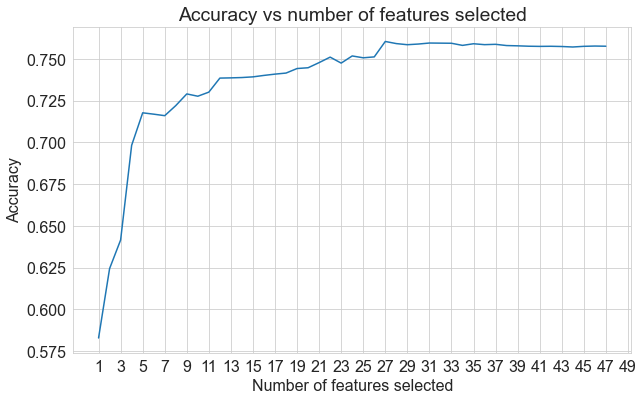

In [6]:
# plotting the results
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(rfecv.cv_results_['mean_test_score'])+1), rfecv.cv_results_['mean_test_score'])
plt.ylabel('Accuracy')
plt.xlabel('Number of features selected')
plt.xticks(np.arange(1, 51, 2))
plt.title('Accuracy vs number of features selected')
plt.show()

The accuracy is better with all model selected hence no need of droppin some features.

In [7]:
columns_to_select = X_train.columns[rfecv.support_]

## Using Grid Search I will locate the best parameters

In [8]:
#  setting up the grid parameters
param_grid = {
    'solver': ['sag', 'saga'],
    'max_iter': [1000,3000]
}


In [9]:
logreg = LogisticRegression(random_state=21)
logreg_gridcv = GridSearchCV(logreg, param_grid=param_grid, scoring='accuracy', cv=3)
logreg_gridcv.fit(X_train, y_train)

logreg_gridcv_results = logreg_gridcv.cv_results_

In [10]:
# Displaying the parameters that lead to an optimum model
logreg_gridcv.best_params_

{'max_iter': 1000, 'solver': 'sag'}

The grid search picked  paramaters {'C': 1, 'max_iter': 100, 'solver': 'sag'} that lead to an optimum model

In [11]:
tunned_model = LogisticRegression(random_state=21, solver='sag', max_iter=1000)

vanilla_model_cv_log_loss = cross_val_score(vanilla_logreg, X_train[columns_to_select], y_train, cv=3, scoring='recall')
vanilla_model_cv_accuracy_score = cross_val_score(vanilla_logreg, X_train[columns_to_select], y_train, cv=3, scoring='accuracy')

tunned_model_cv_log_loss = cross_val_score(tunned_model, X_train[columns_to_select], y_train, cv=3, scoring='recall')
tunned_model_cv_accuracy_score = cross_val_score(tunned_model, X_train[columns_to_select], y_train, cv=3, scoring='accuracy')

# comparing the results
print('K-fold cross-validation results for the vanilla model')
print('The mean recall score is:\t', vanilla_model_cv_log_loss.mean())
print('The mean accuracy score is:\t', vanilla_model_cv_accuracy_score.mean())
print()
print('K-fold cross-validation results for the tunned model')
print('The mean recall score is:\t', tunned_model_cv_log_loss.mean())
print('The mean accuracy score is:\t', tunned_model_cv_accuracy_score.mean())

K-fold cross-validation results for the vanilla model
The mean recall score is:	 0.689669071509746
The mean accuracy score is:	 0.7591453903019266

K-fold cross-validation results for the tunned model
The mean recall score is:	 0.689669071509746
The mean accuracy score is:	 0.7591453903019266


The difference in the performance of the two models is low for judgement. Hence will stick with the vanilla model as the best one.

In [12]:
best_logistic_regression_model = vanilla_logreg

In [16]:
best_logistic_regression_model.fit(X_train[columns_to_select], y_train)

LogisticRegression(max_iter=1000, random_state=21, solver='saga')

In [17]:
y_preds_best = best_logistic_regression_model.predict(X_test[columns_to_select])

The how the best model performs on unseen data

In [18]:
print('Best model score')
scores(y_test, y_preds_best)

Best model score
The precision score is:	 0.8480862817308957
The recall score is:	 0.99721620785648
The accuracy score is:	 0.8461841070023604
The f1 score is:	 0.9166252043499894


In [20]:
y_test.value_counts()

1    6466
0    1160
Name: 0, dtype: int64

In [21]:
pd.Series(y_preds_best).value_counts()

1    7603
0      23
dtype: int64

## Confusion matrix

/home/iain/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


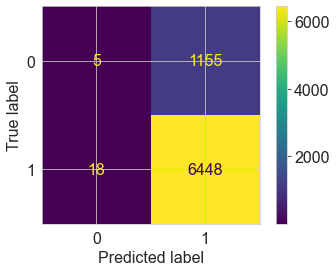

In [19]:
plot_confusion_matrix(best_logistic_regression_model, X_test[columns_to_select], y_test)
plt.show()

## Interpretating the Final Logistic Regression Model

* Precision-Score - If the model assigns 1 then there is a 86% chance that a water pump is actually non functional. (0.8599366478446495)
* Recal-Score - If a given water pump is actually 1 (non-functional) then there is a 97.1% that this model will label it as 1 (non-functional), and a 2.9% chance that it will incorrectly label it as 0 (functional but need repair). This is an improvement from the vanilla model
* Accuracy-Score - The model accrately assigns 84% to the correct label.

